# Hybrid quantum neural network for binary classification with PennyLane

---

This notebook shows the implementation of a quantum neural network (QNN) for a binary classification task using the NASA Near-Earth Object (NEO) dataset. We defined our feature maps and parameterized quantum circuits using PennyLane modules, while using PyTorch for the overall training and testing of the model.

### $\text{Background}$
---
Let's say we have a dataset $\mathcal{D} = \lbrace (\vec{x}_{i}, y_{i})\rbrace_{i = 1}^{N}$, where $\vec{x}_{i} \in \mathbb{R}^{d}$ is the classical data and $y \in \lbrace 0, 1 \rbrace$ represents the classification labels. To implement a QNN, we first map the classical data $\vec{x}$ into an $n$-qubit quantum state that belongs to a large Hilbert space. To do so, we use a data-encoding unitary operator or **feature map**:

$$
| \psi_{\mathrm{enc}}(\vec{x}) \rangle = \hat{U}_{\mathrm{enc}}(\vec{x}) | 0^{\otimes n} \rangle.
$$

Once the classical data has been encoded into a quantum state, we implement a variational parametrized quantum circuit (VPQC) or ansatz, which carries the trainable part of the model:

$$
| \psi(\vec{x}, \vec{\theta}) \rangle = \hat{U}(\vec{\theta}) \hat{U}_{\mathrm{enc}}(\vec{x}) | 0^{\otimes n} \rangle.
$$

Here, $\vec{\theta} \in \mathbb{R}^{p}$ is the set of trainable parameters, and generally speaking, the PQC consists of $L$ parametrized unitary operators, also called **layers**,

$$
\hat{U}(\vec{\theta}) = \prod_{l = 1}^{L} \hat{U}_{l}(\vec{\theta}).
$$

With this, we define a **quantum model** in the following fashion:

$$
f_{\vec{\theta}}\,(\vec{x}) = \langle 0^{\otimes n} | \hat{U}^{\dagger}_{\mathrm{enc}}(\vec{x}) \hat{U}^{\dagger}(\vec{\theta}) \hat{O} \hat{U}(\vec{\theta}) \hat{U}_{\mathrm{enc}}(\vec{x}) | 0^{\otimes n} \rangle,
$$

where we define a real-valued function $f_{\vec{\theta}}\,(\vec{x}) : \mathbb{R}^{d} \to \mathbb{R}$ by measuring an observable $\hat{O}$. For a binary classification task, we typically use the Pauli $\hat{Z}$ gate, which yields the eigenvalues $\pm 1$. These eigenvalues can be reinterpreted as $0$ or $1$ based on the measured probability:

$$
p = \dfrac{1 + f_{\vec{\theta}}\,(\vec{x})}{2} = 
    \left\lbrace
    \begin{array}{cl}
        0 & \text{for} \hspace{1ex} f_{\vec{\theta}}\,(\vec{x}) = -1, \\
        %
        1 & \text{for} \hspace{1ex} f_{\vec{\theta}}\,(\vec{x}) = +1.
    \end{array}
    \right.
$$

As in classical learning tasks, the QNN training is formulated as an empirical risk minimization problem, that is, minimizing a loss function. Mathematically, this is formulated as follows:

$$
\begin{align*}
    \vec{\theta}^{*} &= \mathrm{argmin}_{\vec{\theta}} \mathcal{L}(\vec{\theta}), \\
    %
    \mathcal{L}(\vec{\theta}) &= \dfrac{1}{N} \sum_{i = 1}^{N} \ell(f_{\vec{\theta}}\,(\vec{x}_{i}), y_{i}).
\end{align*}
$$

The function $\mathcal{L}(\vec{\theta})$ is typically defined as an empirical risk, where $\ell(\cdot, \cdot)$ corresponds to a task-dependent loss. One appropriate loss function for a binary classification task is the binary cross-entropy loss, used for this particular work:

$$
\ell_{\mathrm{BCE}}(y, \hat{y}) = -[y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})]. 
$$

In the previous equation, $y$ and $\hat{y}$ are the true and predicted labels, respectively. Furthermore, we considered one qubit per feature, given a total of five qubits.

# $\text{Model}$

### $\text{Data processing}$
---
With this context, we are able to discuss the model. We start by calling the necessary libraries.

In [ ]:
import numpy as np
import pandas as pd
import pennylane as qml
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# TORCH MODULES
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import (
    Dataset, 
    DataLoader, 
    WeightedRandomSampler)

# PLOT PARAMETERS
plt.rcParams.update({
    'lines.linewidth': 2,               # linewidth
    'font.family': 'Helvetica Neue',    # font
    'mathtext.fontset': 'cm',           # math font
    'mathtext.default': 'it',           # math font style
    'font.size': 24,                    # font size
    'axes.titlesize': 24,               # title size
    'axes.grid': True,                  # grid
    'grid.linestyle': '-.',             # grid style
    'axes.facecolor': '#ECECEC',        # background color for the axes
    'figure.facecolor': '#FFFFFF',      # background color for the axes
    'legend.facecolor': '#FFFFFF'       # background color for the legend
})

Here, we declare the global variables:
- Device: CPU or CUDA.
- Seed (for debugging)
- Number of qubits (one per feature)

In [3]:
# GLOBAL VARIABLES
DEVICE = 'cuda'
SEED = 42
QUBITS = 5

The next part was handling the data using two main classes using PyTorch. 
- The `NasaDataset` class converts the data into PyTorch `float32` tensors during initialization for a more efficient processing.
- The `DataHandler` loads the CSV file, selects the relevant features, and splits the data into training, validation, and testing sets using stratification to mantain class balance. 
- We used `MinMaxScaler` to map features to the range $[0, \pi]$ to prevent wraparounds that could arise from using `StandardScaler`.

In [29]:
class NasaDataset(Dataset):
    def __init__(self, data, targets, device = None):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.targets = torch.tensor(targets, dtype = torch.float32)

        if device:
            self.data = self.data.to(device)
            self.targets = self.targets.to(device)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.targets[index]

class DataHandler:
    def __init__(self, csv_path, batch_size = 32, seed = 42, test_size = 0.3, num_workers = 0):
        self.csv_path = csv_path
        self.batch_size = batch_size
        self.seed = seed
        self.test_size = test_size
        self.num_workers = num_workers
        self.feats = [
            "est_diameter_min", "est_diameter_max",
            "relative_velocity", "miss_distance", "absolute_magnitude"
        ]

    def load_and_process(self):
        raw_data = pd.read_csv(self.csv_path)

        data = raw_data[self.feats].values.astype(np.float32)
        targets = raw_data["hazardous"].values.astype(np.float32)

        # Split data into training and temp
        data_tr, data_temp, targets_tr, targets_temp = train_test_split(
            data, targets, test_size = 0.3, random_state = self.seed, stratify = targets
            )
        
        # Split validation versus test (50/50 of temp)
        data_val, data_test, targets_val, targets_test = train_test_split(
            data_temp, targets_temp, test_size = 0.5, random_state = self.seed, stratify = targets_temp
            )

        scaler = MinMaxScaler(feature_range = (0, np.pi))

        data_tr = scaler.fit_transform(data_tr).astype(np.float32)
        data_val = scaler.transform(data_val).astype(np.float32)
        data_test = scaler.transform(data_test).astype(np.float32)

        # Create datasets
        self.train_ds = NasaDataset(data_tr, targets_tr)
        self.val_ds = NasaDataset(data_val, targets_val)
        self.test_ds = NasaDataset(data_test, targets_test)

        return self.train_ds, self.val_ds, self.test_ds

    def get_dataloaders(self):
        targets = self.train_ds.targets.long()
        
        class_counts = torch.bincount(targets)
        class_weights = 1.0 / class_counts.float()
        sample_weights = class_weights[targets]

        sampler = WeightedRandomSampler(
            weights = sample_weights,
            num_samples = len(sample_weights),
            replacement = True
        )

        generator = torch.Generator()
        generator.manual_seed(self.seed)

        train_loader = DataLoader(
            self.train_ds,
            batch_size = self.batch_size,
            sampler = sampler,
            num_workers = self.num_workers,
            pin_memory = True,
            worker_init_fn = self.seed_worker,
            generator = generator
        )

        val_loader = DataLoader(
            self.val_ds,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = self.num_workers,
            pin_memory = True
        )

        test_loader = DataLoader(
            self.test_ds,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = self.num_workers,
            pin_memory = True
        )
        
        return train_loader, val_loader, test_loader

    @staticmethod
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)

Overall, 70% of the data was allocated for training, while the remaining data was split evenly between validation (15%) and testing (15%). The NEO dataset has a large imbalance of the two classes. To address this issue, we used the `WeightedRandomSampler` function from `torch.utils.data` to construct balanced training batches containing an equal proportion of hazardous and non-hazardous samples. This function reused hazardous data to construct balanced batches until all non-hazardous data had been used, and we preserved the original class distribution for the validation and test sets.

Also, we used the parameter `num_workers`. In the `DataLoader`, `num_workers` sets how many subprocesses are used for data loading. In this case, `num_workers = 2` makes the CPU to spawn two separate processes to "pre-fetch" the next batches of data while the GPU is calculating the current batch.

### $\text{Feature maps and parametrized quantum circuits}$

---
On the other hand, for this particular model, we defined the following three quantum feature maps:
$$
\begin{align*}
    \hat{U}_{\mathrm{enc}, 1}(\vec{x}) &= \bigotimes_{j = 0}^{4} \hat{R}_{y}(x_{j}),\\
    %
    \hat{U}_{\mathrm{enc}, 2}(\vec{x}) &= \left[ \bigotimes_{j = 0}^{4} \hat{R}_{x}(x_{j}) \right] \left[ \bigotimes_{j = 0}^{4} \hat{R}_{z}(x_{j}) \right], \\
    %
    \hat{U}_{\mathrm{enc}, 3}(\vec{x}) &= \prod_{r = 1}^{R} \left[ \left( \prod_{0 \leq j < k \leq 4} \mathrm{e}^{-\mathrm{i} x_{j} x_{k} Z_{j} Z_{k}} \right) \left( \bigotimes_{j = 0}^{4} \hat{R}_{z}(2 x_{j}) \right) \left( \bigotimes_{j = 0}^{4} \hat{H}_{j} \right) \right].
\end{align*}
$$

Here, $\hat{R}$ represents a rotation gate, and $r$ is the number of repetions. We used $R = 2$, as the authors from the original paper did. 

In [ ]:
# Feature maps or data encoding circuits
def feature_map_1(data, n_qubits, scale = 1.0):
    qml.AngleEmbedding(features = data * scale, wires = range(n_qubits), rotation = 'Y')

def feature_map_2(data, n_qubits, scale = 1.0):
    qml.AngleEmbedding(features = data * scale, wires = range(n_qubits), rotation = 'Z')
    qml.AngleEmbedding(features = data * scale, wires = range(n_qubits), rotation = 'X')

def feature_map_3(data, n_qubits, reps = 2):
    assert len(data) == n_qubits, f"Input size {len(data)} must match n_qubits {n_qubits}"
    for _ in range(reps):
        for index in range(n_qubits):
            qml.Hadamard(wires = index)

        for index in range(n_qubits):
            qml.RZ(2.0 * data[index], wires = index)

        for idx0 in range(n_qubits):
            for idx1 in range(idx0 + 1, n_qubits):
                qml.CNOT(wires = [idx0, idx1])
                qml.RZ(2.0 * data[idx0] * data[idx1], wires = idx1)
                qml.CNOT(wires = [idx0, idx1])

Furthermore, we implemented three different ansatze:
$$
\begin{align*}
    \hat{U}_{1}(\vec{\theta}) &= \prod_{\ell = 1}^{L} \left[ \left( \prod_{j = 0}^{4} \mathrm{CNOT}_{j, j + 1}{}^{(\ell)} \right) \left( \bigotimes_{j = 0}^{4} \hat{R}_{y}(\theta_{\ell, j}) \right) \right], \\
    %
    \hat{U}_{2}(\vec{\theta}) &= \prod_{\ell = 1}^{L} \left[ \left( \prod_{j = 4}^{0} \mathrm{CNOT}_{j + 1, j}{}^{(\ell)} \right) \left( \bigotimes_{j = 0}^{4} \hat{R}_{z}(\theta_{\ell, j}) \hat{R}_{x}(\theta_{\ell, j}) \right) \right].
\end{align*}
$$

In [ ]:
# Variational ansatze
def variational_ansatz_1(angle, n_qubits):
    n_layers, n_wires = angle.shape
    assert n_wires == n_qubits, f"Expected {n_qubits} wires, got {n_wires}"
    
    for layer in range(n_layers):
        for qubit in range(n_wires):
            qml.RY(phi = angle[layer, qubit], wires = qubit)
        for qubit in range(n_wires):
            qml.CNOT(wires = [qubit, (qubit + 1) % n_wires])

def variational_ansatz_2(angle, n_qubits):
    n_layers, n_wires = angle.shape
    assert n_wires == n_qubits, f"Expected {n_qubits} wires, got {n_wires}"
    
    for layer in range(n_layers):
        for qubit in range(n_wires):
            qml.RX(angle[layer, qubit], wires = qubit)
            qml.RZ(angle[layer, qubit], wires = qubit)
        for qubit in range(n_wires - 1, -1, -1):
            qml.CNOT(wires = [(qubit + 1) % n_wires, qubit])

We create a dictionary with the feature maps and ansatzë available to test.

In [34]:
FEATURE_MAPS = {
    "fm1": feature_map_1,
    "fm2": feature_map_2,
    "fm3": feature_map_3}

ANSATZE = {
    "ansatz1": variational_ansatz_1,
    "ansatz2": variational_ansatz_2}

With the feature maps and ansatzë ready, we can construct the QNN. 

In [17]:
class QNNClassifier(nn.Module):
    def __init__(self, angle_shape, feature_map_name = "fm1", ansatz_name = "ansatz1", n_qubits = QUBITS):
        super().__init__()
        self.angle = nn.Parameter(torch.randn(angle_shape, dtype = torch.float32) * 0.01)
        self.n_qubits = n_qubits
        
        dev = qml.device("lightning.qubit", wires = n_qubits)
        @qml.qnode(dev, interface = "torch", diff_method = "adjoint")
        def circuit(data, angle):
            feature_map = FEATURE_MAPS[feature_map_name]
            ansatz = ANSATZE[ansatz_name]
            
            if feature_map_name == "fm3" and data.ndim > 1:
                for _ in range(2):
                    for index in range(n_qubits):
                        qml.Hadamard(wires = index)
                    for index in range(n_qubits):
                        qml.RZ(2.0 * data[:, index], wires = index)
                    for idx0 in range(n_qubits):
                        for idx1 in range(idx0 + 1, n_qubits):
                            qml.CNOT(wires = [idx0, idx1])
                            qml.RZ(2.0 * data[:, idx0] * data[:, idx1], wires = idx1)
                            qml.CNOT(wires = [idx0, idx1])
            else:
                feature_map(data, n_qubits = n_qubits)
            ansatz(angle, n_qubits)
            return qml.expval(qml.PauliZ(0))
        self.circuit = circuit

    def forward(self, data):
        data = data.to(torch.float32)
        expvals = self.circuit(data, self.angle)
        probabilities = (expvals + torch.tensor(1.0, dtype = torch.float32)) / torch.tensor(2.0, dtype = torch.float32)

        if probabilities.ndim == 1:
            return probabilities.unsqueeze(1)
        return probabilities

The expectation values produced by the QNN were interpreted as class probabilities. Accordingly, 
- the gradients of the loss function with respect to the circuit parameters were computed using the **adjoint differentiation method**; 
- we recorded the test accuracy across different feature maps, ansatzë, and circuit depths; 
- all quantum circuits were executed using PennyLane’s `lightning.qubit` backend;
- the gradient computation was performed by setting `diff_method = "adjoint"`.

### $\text{Training and testing loops}$
---
The training loop is where the QNN parameters are updated based on the error.

In [ ]:
def train_and_evaluate(qnn, 
                       train_loader,
                       val_loader,
                       test_loader,
                       n_epochs = 50,
                       n_batches = None,
                       device = DEVICE, 
                       min_learn_rate = 1e-3,
                       max_learn_rate = 1e-1,
                       feature_map_name = "fm1",
                       ansatz_name = "ansatz1"):

    qnn = qnn.to(device)

    total_train_batches = len(train_loader)
    batches_per_epoch = n_batches if n_batches is not None else total_train_batches
    optimizer = torch.optim.Adam(qnn.parameters(), lr = min_learn_rate)

    scheduler = torch.optim.lr_scheduler.CyclicLR(
        optimizer,
        base_lr = min_learn_rate,
        max_lr = max_learn_rate,
        step_size_up = batches_per_epoch // 2,
        mode = "triangular",
        cycle_momentum = False
    )

    loss_function = nn.BCELoss()
    
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []}
    
    # Determine batches per epoch
    total_train_batches = len(train_loader)
    batches_per_epoch = n_batches if n_batches is not None else total_train_batches
    
    print(f"Training Configuration:")
    print(f"  1. Feature map: {feature_map_name}")
    print(f"  2. Ansatz: {ansatz_name}")
    print(f"  3. Learning rate range: [{min_learn_rate}, {max_learn_rate}]")
    print(f"  4. Device: {device}")
    print(f"  5. Total train batches available: {total_train_batches}")
    print(f"  6. Batches per epoch: {batches_per_epoch}")
    print(f"  7. Epochs: {n_epochs}\n")
    
    # Training loop
    for epoch in range(n_epochs):
        # Training phase
        qnn.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        pbar = tqdm(enumerate(train_loader), 
                   total = batches_per_epoch,
                   desc = f"Epoch {epoch + 1}/{n_epochs} [Train]",
                   leave = True)
        
        for batch_idx, (data, targets) in pbar:
            if batch_idx >= batches_per_epoch:
                break
                
            data, targets = data.to(device), targets.to(device)
            targets = targets.to(torch.float32).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = qnn(data)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            predictions = (outputs > 0.5).float()
            train_correct += (predictions == targets).sum().item()
            train_total += targets.size(0)
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * train_correct / train_total:.2f}%'
            })
        
        pbar.close()
        
        # Validation phase
        qnn.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, targets in tqdm(val_loader, 
                                       desc = f"Epoch {epoch + 1}/{n_epochs} [Val]  ",
                                       leave = True):
                data, targets = data.to(device), targets.to(device)
                targets = targets.to(torch.float32).unsqueeze(1)
                
                outputs = qnn(data)
                loss = loss_function(outputs, targets)
                
                val_loss += loss.item()
                predictions = (outputs > 0.5).float()
                val_correct += (predictions == targets).sum().item()
                val_total += targets.size(0)
        
        # Epoch metrics
        avg_train_loss = train_loss / batches_per_epoch
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = 100.0 * train_correct / train_total
        val_accuracy = 100.0 * val_correct / val_total
        
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(train_accuracy)
        history["val_acc"].append(val_accuracy)
        
        # Epoch summary
        print(f"Epoch {epoch+1}/{n_epochs}: "
              f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_accuracy:.2f}% | "
              f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_accuracy:.2f}%")
    
    # Testing phase
    print("\n" + "="*70)
    print("TESTING PHASE")
    print("="*70)
    
    qnn.eval()
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in tqdm(test_loader, desc = "Testing"):
            data, targets = data.to(device), targets.to(device)
            targets = targets.unsqueeze(1)
            
            outputs = qnn(data)
            loss = loss_function(outputs, targets)
            
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    avg_test_loss = test_loss / len(test_loader)
    all_predictions = np.array(all_predictions).flatten()
    all_targets = np.array(all_targets).flatten()
    test_accuracy = accuracy_score(all_targets, all_predictions)
    
    print(f"\nTest Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print("\nClassification Report:")
    print(classification_report(all_targets, all_predictions, 
                                target_names = ["Not Hazardous", "Hazardous"]))
    print("\nConfusion Matrix:")
    confusion_mtrx = confusion_matrix(all_targets, all_predictions)
    print(confusion_mtrx)
    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_mtrx, display_labels = [0, 1])
    disp.plot(cmap = "Blues")

    # Percentages
    cm_percent = confusion_mtrx / confusion_mtrx.sum(axis = 1, keepdims = True)
    print(np.round(cm_percent * 100, 2))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm_percent, display_labels = [0, 1])
    disp.plot(cmap = "Blues")
    return history, avg_test_loss, test_accuracy

We implemented a training loop. The model 
- was trained over a fixed number of epochs;
- was partitioned into smaller groups of samples (mini-batch gradient descent) to provide more memory-efficient and stable gradient estimates; 
- used the command `optimizer.zero_grad()` to clear out the gradients from the previous batch so PyTorch does not accumulate (add) gradients that could lead to incorrect parameter updates;
- implemented the binary-cross entropy and the `loss.backward()` command, with calculates the gradient of the loss with respect to the QNN parameters. 

Moving to the testing loop, the model
- applied the `torch.no_grad()` module to disable the gradient calculation since we are only predicitng and not training;
- used the `qnn.eval()` function to set the model into the evaluation mode;
- calculated the finall accuracy and generated a confusion matrix to visualize the hazardous and non-hazardous objects correctly identified.

Next, we create a function for plotting purposes.

In [18]:
def plot_training_history(history, feature_map_name = "fm1", ansatz_name = "ansatz1", layers = 2, batch_size = 32):
    fig, axes = plt.subplots(1, 2, figsize = (18, 8))
    
    # Plot loss
    axes[0].plot(history["train_loss"], label = "Training loss", linewidth = 2, color = "#D40000")
    axes[0].plot(history["val_loss"], label = "Validation loss", linewidth = 2, color = "#0055AA")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    
    # Plot accuracy
    axes[1].plot(history["train_acc"], label = "Training accuracy", linewidth = 2, color = "#D40000")
    axes[1].plot(history["val_acc"], label = "Validation accuracy", linewidth = 2, color = "#0055AA")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(f'training_history_{feature_map_name}_{ansatz_name}_{layers}_{batch_size}.pdf', dpi = 300)

Finally, we create a function to test the model performance, with the option of selecting different hyperparameters, feature maps, and ansatz. 

In [ ]:
def run_experiment(feature_map_name = "fm1", 
                   ansatz_name = "ansatz1", 
                   layers = 2,
                   n_epochs = 50,
                   n_batches = None,
                   batch_size = 32,
                   min_learn_rate = 1e-3,
                   max_learn_rate = 1e-1):
    
    # Initialize Data Handler
    data_handler = DataHandler(
        csv_path= " neo.csv", 
        batch_size = batch_size,
        num_workers = 2
    )
    
    # Process and get loaders
    data_handler.load_and_process()
    train_loader, val_loader, test_loader = data_handler.get_dataloaders()
    
    # Determine configuration
    if ansatz_name == "ansatz3":
        angle_shape = (layers, 20)
        n_qubits = 5
        print(f"Using ansatz3: 5 qubits, 20 parameters per layer")
    else:
        angle_shape = (layers, QUBITS)
        n_qubits = QUBITS
    
    print(f"Model: {layers} layer(s), angle_shape = {angle_shape}\n")
    
    # Create QNN
    qnn = QNNClassifier(
        angle_shape = angle_shape,
        feature_map_name = feature_map_name,
        ansatz_name = ansatz_name,
        n_qubits = n_qubits
    )
    
    # Train, validate, and test
    history, test_loss, test_acc = train_and_evaluate(
        qnn = qnn,
        train_loader = train_loader,
        val_loader = val_loader,
        test_loader = test_loader,
        n_epochs = n_epochs,
        n_batches = n_batches,
        device = DEVICE,
        min_learn_rate = min_learn_rate,
        max_learn_rate = max_learn_rate,
        feature_map_name = feature_map_name,
        ansatz_name = ansatz_name
    )

    # Plot results
    plot_training_history(history, feature_map_name, ansatz_name, layers, batch_size)
    return qnn, history, test_loss, test_acc

### $\text{Tests}$
---
In this section, we ran three different tests:

<center>

| Feature map | Ansatz | Layers | Epochs | Batches | Batch size | Min. learn. rate | Max. learn. rate |
| :---------: | :----: | :----: | :----: | :-----: | :--------: | :--------------: | :--------------: |
| 1           | 1      | 2      | 100    | 64      | 32         | 0.001            | 0.1              |
| 1           | 1      | 3      | 100    | 64      | 32         | 0.001            | 0.1              |
| 2           | 1      | 2      | 50     | 96      | 32         | 0.001            | 0.1              |

</center>

Model: 2 layer(s), angle_shape = (2, 5)

Training Configuration:
  1. Feature map: fm1
  2. Ansatz: ansatz1
  3. Learning rate range: [0.001, 0.1]
  4. Device: cuda
  5. Total train batches available: 1988
  6. Batches per epoch: 64
  7. Epochs: 100



Epoch 1/100 [Val]  : 100%|██████████| 426/426 [00:25<00:00, 16.79it/s]

Epoch 1/100: Train Loss = 0.5363, Train Acc = 81.25% | Val Loss = 0.5278, Val Acc = 78.13%



Epoch 2/100 [Val]  : 100%|██████████| 426/426 [00:24<00:00, 17.47it/s]

Epoch 2/100: Train Loss = 0.5314, Train Acc = 79.88% | Val Loss = 0.5412, Val Acc = 76.77%



Epoch 3/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 19.13it/s]

Epoch 3/100: Train Loss = 0.5173, Train Acc = 85.69% | Val Loss = 0.4870, Val Acc = 79.56%



Epoch 4/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 19.17it/s]

Epoch 4/100: Train Loss = 0.5333, Train Acc = 79.59% | Val Loss = 0.6118, Val Acc = 68.60%



Epoch 5/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 19.16it/s]

Epoch 5/100: Train Loss = 0.5354, Train Acc = 80.27% | Val Loss = 0.4837, Val Acc = 79.65%



Epoch 6/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.85it/s]

Epoch 6/100: Train Loss = 0.5369, Train Acc = 81.45% | Val Loss = 0.4826, Val Acc = 79.66%



Epoch 7/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 19.32it/s]

Epoch 7/100: Train Loss = 0.5260, Train Acc = 85.60% | Val Loss = 0.5353, Val Acc = 77.67%



Epoch 8/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 19.32it/s]

Epoch 8/100: Train Loss = 0.5329, Train Acc = 84.42% | Val Loss = 0.5610, Val Acc = 75.56%



Epoch 9/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.98it/s]

Epoch 9/100: Train Loss = 0.5367, Train Acc = 81.25% | Val Loss = 0.5738, Val Acc = 72.79%



Epoch 10/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.81it/s]

Epoch 10/100: Train Loss = 0.5348, Train Acc = 81.79% | Val Loss = 0.5182, Val Acc = 78.29%



Epoch 11/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 19.00it/s]

Epoch 11/100: Train Loss = 0.5420, Train Acc = 81.64% | Val Loss = 0.4949, Val Acc = 79.13%



Epoch 12/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.38it/s]

Epoch 12/100: Train Loss = 0.5285, Train Acc = 81.49% | Val Loss = 0.5249, Val Acc = 78.14%



Epoch 13/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.74it/s]

Epoch 13/100: Train Loss = 0.5287, Train Acc = 81.40% | Val Loss = 0.5093, Val Acc = 78.69%



Epoch 14/100 [Val]  : 100%|██████████| 426/426 [00:23<00:00, 18.27it/s]

Epoch 14/100: Train Loss = 0.5344, Train Acc = 81.93% | Val Loss = 0.5433, Val Acc = 76.68%



Epoch 15/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.65it/s]

Epoch 15/100: Train Loss = 0.5275, Train Acc = 85.64% | Val Loss = 0.5179, Val Acc = 78.30%



Epoch 16/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.88it/s]

Epoch 16/100: Train Loss = 0.5230, Train Acc = 86.57% | Val Loss = 0.5096, Val Acc = 78.66%



Epoch 17/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 19.08it/s]

Epoch 17/100: Train Loss = 0.5285, Train Acc = 83.69% | Val Loss = 0.5224, Val Acc = 78.30%



Epoch 18/100 [Val]  : 100%|██████████| 426/426 [00:23<00:00, 18.48it/s]

Epoch 18/100: Train Loss = 0.5294, Train Acc = 80.08% | Val Loss = 0.4632, Val Acc = 80.89%



Epoch 19/100 [Val]  : 100%|██████████| 426/426 [00:23<00:00, 18.38it/s]

Epoch 19/100: Train Loss = 0.5320, Train Acc = 81.69% | Val Loss = 0.5405, Val Acc = 76.75%



Epoch 20/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.57it/s]

Epoch 20/100: Train Loss = 0.5260, Train Acc = 84.77% | Val Loss = 0.5790, Val Acc = 72.69%



Epoch 21/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.56it/s]

Epoch 21/100: Train Loss = 0.5346, Train Acc = 79.98% | Val Loss = 0.4633, Val Acc = 80.87%



Epoch 22/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.61it/s]

Epoch 22/100: Train Loss = 0.5278, Train Acc = 78.96% | Val Loss = 0.5013, Val Acc = 78.97%



Epoch 23/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.60it/s]

Epoch 23/100: Train Loss = 0.5218, Train Acc = 84.72% | Val Loss = 0.5793, Val Acc = 72.71%



Epoch 24/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.90it/s]

Epoch 24/100: Train Loss = 0.5307, Train Acc = 82.23% | Val Loss = 0.5259, Val Acc = 78.10%



Epoch 25/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.90it/s]

Epoch 25/100: Train Loss = 0.5248, Train Acc = 84.08% | Val Loss = 0.5602, Val Acc = 74.67%



Epoch 26/100 [Val]  : 100%|██████████| 426/426 [00:23<00:00, 18.07it/s]

Epoch 26/100: Train Loss = 0.5239, Train Acc = 83.15% | Val Loss = 0.5338, Val Acc = 77.70%



Epoch 27/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.78it/s]

Epoch 27/100: Train Loss = 0.5233, Train Acc = 84.08% | Val Loss = 0.4901, Val Acc = 79.57%



Epoch 28/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.97it/s]

Epoch 28/100: Train Loss = 0.5286, Train Acc = 81.10% | Val Loss = 0.5284, Val Acc = 78.07%



Epoch 29/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 19.19it/s]

Epoch 29/100: Train Loss = 0.5291, Train Acc = 82.71% | Val Loss = 0.5605, Val Acc = 74.74%



Epoch 30/100 [Val]  : 100%|██████████| 426/426 [00:23<00:00, 18.38it/s]

Epoch 30/100: Train Loss = 0.5193, Train Acc = 83.59% | Val Loss = 0.5819, Val Acc = 71.78%



Epoch 31/100 [Val]  : 100%|██████████| 426/426 [00:23<00:00, 18.36it/s]

Epoch 31/100: Train Loss = 0.5251, Train Acc = 83.40% | Val Loss = 0.5531, Val Acc = 75.71%



Epoch 32/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.87it/s]

Epoch 32/100: Train Loss = 0.5303, Train Acc = 85.06% | Val Loss = 0.5349, Val Acc = 77.60%



Epoch 33/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.55it/s]

Epoch 33/100: Train Loss = 0.5254, Train Acc = 81.84% | Val Loss = 0.4848, Val Acc = 79.55%



Epoch 34/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.67it/s]

Epoch 34/100: Train Loss = 0.5379, Train Acc = 79.39% | Val Loss = 0.5002, Val Acc = 78.97%



Epoch 35/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 18.73it/s]

Epoch 35/100: Train Loss = 0.5251, Train Acc = 85.11% | Val Loss = 0.5330, Val Acc = 77.67%



Epoch 36/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.50it/s]

Epoch 36/100: Train Loss = 0.5262, Train Acc = 85.84% | Val Loss = 0.5229, Val Acc = 78.17%



Epoch 37/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.48it/s]

Epoch 37/100: Train Loss = 0.5154, Train Acc = 84.72% | Val Loss = 0.4533, Val Acc = 81.42%



Epoch 38/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.38it/s]

Epoch 38/100: Train Loss = 0.5224, Train Acc = 80.27% | Val Loss = 0.5046, Val Acc = 78.97%



Epoch 39/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.41it/s]

Epoch 39/100: Train Loss = 0.5363, Train Acc = 82.96% | Val Loss = 0.5124, Val Acc = 78.66%



Epoch 40/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.47it/s]

Epoch 40/100: Train Loss = 0.5301, Train Acc = 83.45% | Val Loss = 0.5576, Val Acc = 74.74%



Epoch 41/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.44it/s]

Epoch 41/100: Train Loss = 0.5300, Train Acc = 83.98% | Val Loss = 0.4925, Val Acc = 79.18%



Epoch 42/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 19.36it/s]

Epoch 42/100: Train Loss = 0.5289, Train Acc = 82.67% | Val Loss = 0.5256, Val Acc = 78.12%



Epoch 43/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.40it/s]

Epoch 43/100: Train Loss = 0.5285, Train Acc = 82.86% | Val Loss = 0.5086, Val Acc = 78.73%



Epoch 44/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.48it/s]

Epoch 44/100: Train Loss = 0.5237, Train Acc = 84.67% | Val Loss = 0.5301, Val Acc = 77.73%



Epoch 45/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.54it/s]

Epoch 45/100: Train Loss = 0.5333, Train Acc = 82.76% | Val Loss = 0.5187, Val Acc = 78.29%



Epoch 46/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.52it/s]

Epoch 46/100: Train Loss = 0.5304, Train Acc = 81.98% | Val Loss = 0.5191, Val Acc = 78.28%



Epoch 47/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.44it/s]

Epoch 47/100: Train Loss = 0.5284, Train Acc = 84.28% | Val Loss = 0.5007, Val Acc = 78.96%



Epoch 48/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.60it/s]

Epoch 48/100: Train Loss = 0.5390, Train Acc = 81.69% | Val Loss = 0.5199, Val Acc = 78.28%



Epoch 49/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.84it/s]

Epoch 49/100: Train Loss = 0.5293, Train Acc = 85.94% | Val Loss = 0.5371, Val Acc = 77.59%



Epoch 50/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.61it/s]

Epoch 50/100: Train Loss = 0.5283, Train Acc = 80.66% | Val Loss = 0.4578, Val Acc = 81.12%



Epoch 51/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.57it/s]

Epoch 51/100: Train Loss = 0.5237, Train Acc = 83.01% | Val Loss = 0.4989, Val Acc = 78.97%



Epoch 52/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.51it/s]

Epoch 52/100: Train Loss = 0.5287, Train Acc = 84.47% | Val Loss = 0.5660, Val Acc = 73.73%



Epoch 53/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.51it/s]

Epoch 53/100: Train Loss = 0.5157, Train Acc = 83.84% | Val Loss = 0.5772, Val Acc = 72.71%



Epoch 54/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.45it/s]

Epoch 54/100: Train Loss = 0.5369, Train Acc = 82.81% | Val Loss = 0.5574, Val Acc = 75.53%



Epoch 55/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.54it/s]

Epoch 55/100: Train Loss = 0.5322, Train Acc = 82.96% | Val Loss = 0.5015, Val Acc = 78.98%



Epoch 56/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.48it/s]

Epoch 56/100: Train Loss = 0.5333, Train Acc = 80.18% | Val Loss = 0.4986, Val Acc = 78.97%



Epoch 57/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 19.36it/s]

Epoch 57/100: Train Loss = 0.5303, Train Acc = 83.40% | Val Loss = 0.5552, Val Acc = 75.60%



Epoch 58/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.61it/s]

Epoch 58/100: Train Loss = 0.5258, Train Acc = 86.62% | Val Loss = 0.5259, Val Acc = 78.10%



Epoch 59/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.51it/s]

Epoch 59/100: Train Loss = 0.5284, Train Acc = 83.89% | Val Loss = 0.5555, Val Acc = 74.77%



Epoch 60/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.50it/s]

Epoch 60/100: Train Loss = 0.5337, Train Acc = 83.50% | Val Loss = 0.4722, Val Acc = 80.42%



Epoch 61/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 19.31it/s]

Epoch 61/100: Train Loss = 0.5198, Train Acc = 83.35% | Val Loss = 0.5817, Val Acc = 72.64%



Epoch 62/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.44it/s]

Epoch 62/100: Train Loss = 0.5255, Train Acc = 86.23% | Val Loss = 0.5226, Val Acc = 78.29%



Epoch 63/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.57it/s]

Epoch 63/100: Train Loss = 0.5342, Train Acc = 82.67% | Val Loss = 0.5250, Val Acc = 78.12%



Epoch 64/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.53it/s]

Epoch 64/100: Train Loss = 0.5185, Train Acc = 85.11% | Val Loss = 0.5150, Val Acc = 78.29%



Epoch 65/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.48it/s]

Epoch 65/100: Train Loss = 0.5330, Train Acc = 75.44% | Val Loss = 0.4732, Val Acc = 80.39%



Epoch 66/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.60it/s]

Epoch 66/100: Train Loss = 0.5331, Train Acc = 84.33% | Val Loss = 0.5352, Val Acc = 77.70%



Epoch 67/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.87it/s]

Epoch 67/100: Train Loss = 0.5254, Train Acc = 84.08% | Val Loss = 0.5213, Val Acc = 78.30%



Epoch 68/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.81it/s]

Epoch 68/100: Train Loss = 0.5280, Train Acc = 85.79% | Val Loss = 0.5198, Val Acc = 78.30%



Epoch 69/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.74it/s]

Epoch 69/100: Train Loss = 0.5341, Train Acc = 80.32% | Val Loss = 0.5706, Val Acc = 73.72%



Epoch 70/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.55it/s]

Epoch 70/100: Train Loss = 0.5280, Train Acc = 81.74% | Val Loss = 0.4628, Val Acc = 80.88%



Epoch 71/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.46it/s]

Epoch 71/100: Train Loss = 0.5272, Train Acc = 80.37% | Val Loss = 0.5812, Val Acc = 72.65%



Epoch 72/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.44it/s]

Epoch 72/100: Train Loss = 0.5275, Train Acc = 83.59% | Val Loss = 0.5391, Val Acc = 76.84%



Epoch 73/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.69it/s]

Epoch 73/100: Train Loss = 0.5287, Train Acc = 85.45% | Val Loss = 0.5188, Val Acc = 78.28%



Epoch 74/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.46it/s]

Epoch 74/100: Train Loss = 0.5255, Train Acc = 82.32% | Val Loss = 0.6025, Val Acc = 69.77%



Epoch 75/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.51it/s]

Epoch 75/100: Train Loss = 0.5286, Train Acc = 81.01% | Val Loss = 0.4896, Val Acc = 79.57%



Epoch 76/100 [Val]  : 100%|██████████| 426/426 [00:22<00:00, 19.28it/s]

Epoch 76/100: Train Loss = 0.5366, Train Acc = 79.30% | Val Loss = 0.5804, Val Acc = 72.70%



Epoch 77/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.58it/s]

Epoch 77/100: Train Loss = 0.5340, Train Acc = 81.35% | Val Loss = 0.5166, Val Acc = 78.31%



Epoch 78/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.55it/s]

Epoch 78/100: Train Loss = 0.5230, Train Acc = 83.25% | Val Loss = 0.4928, Val Acc = 79.19%



Epoch 79/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.53it/s]

Epoch 79/100: Train Loss = 0.5297, Train Acc = 80.37% | Val Loss = 0.4676, Val Acc = 80.43%



Epoch 80/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.49it/s]

Epoch 80/100: Train Loss = 0.5235, Train Acc = 80.71% | Val Loss = 0.5325, Val Acc = 77.70%



Epoch 81/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.59it/s]

Epoch 81/100: Train Loss = 0.5215, Train Acc = 86.04% | Val Loss = 0.5158, Val Acc = 78.30%



Epoch 82/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.91it/s]

Epoch 82/100: Train Loss = 0.5344, Train Acc = 83.30% | Val Loss = 0.5256, Val Acc = 78.14%



Epoch 83/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.83it/s]

Epoch 83/100: Train Loss = 0.5227, Train Acc = 86.04% | Val Loss = 0.5373, Val Acc = 77.59%



Epoch 84/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.83it/s]

Epoch 84/100: Train Loss = 0.5394, Train Acc = 82.86% | Val Loss = 0.5129, Val Acc = 78.61%



Epoch 85/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.66it/s]

Epoch 85/100: Train Loss = 0.5268, Train Acc = 83.11% | Val Loss = 0.4869, Val Acc = 79.55%



Epoch 86/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.59it/s]

Epoch 86/100: Train Loss = 0.5342, Train Acc = 78.17% | Val Loss = 0.5279, Val Acc = 78.08%



Epoch 87/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.56it/s]

Epoch 87/100: Train Loss = 0.5354, Train Acc = 82.13% | Val Loss = 0.5561, Val Acc = 74.76%



Epoch 88/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.37it/s]

Epoch 88/100: Train Loss = 0.5251, Train Acc = 84.81% | Val Loss = 0.5145, Val Acc = 78.36%



Epoch 89/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.55it/s]

Epoch 89/100: Train Loss = 0.5281, Train Acc = 83.30% | Val Loss = 0.5526, Val Acc = 75.68%



Epoch 90/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.61it/s]

Epoch 90/100: Train Loss = 0.5333, Train Acc = 82.91% | Val Loss = 0.4855, Val Acc = 79.54%



Epoch 91/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.56it/s]

Epoch 91/100: Train Loss = 0.5182, Train Acc = 83.74% | Val Loss = 0.4715, Val Acc = 80.40%



Epoch 92/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.49it/s]

Epoch 92/100: Train Loss = 0.5257, Train Acc = 82.08% | Val Loss = 0.6040, Val Acc = 69.76%



Epoch 93/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.61it/s]

Epoch 93/100: Train Loss = 0.5290, Train Acc = 81.59% | Val Loss = 0.4980, Val Acc = 79.01%



Epoch 94/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.56it/s]

Epoch 94/100: Train Loss = 0.5238, Train Acc = 83.64% | Val Loss = 0.5362, Val Acc = 77.60%



Epoch 95/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.55it/s]

Epoch 95/100: Train Loss = 0.5412, Train Acc = 80.62% | Val Loss = 0.5741, Val Acc = 72.74%



Epoch 96/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.59it/s]

Epoch 96/100: Train Loss = 0.5254, Train Acc = 83.89% | Val Loss = 0.5153, Val Acc = 78.37%



Epoch 97/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.88it/s]

Epoch 97/100: Train Loss = 0.5315, Train Acc = 83.69% | Val Loss = 0.6322, Val Acc = 66.48%



Epoch 98/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.79it/s]

Epoch 98/100: Train Loss = 0.5231, Train Acc = 85.45% | Val Loss = 0.5304, Val Acc = 77.71%



Epoch 99/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.82it/s]

Epoch 99/100: Train Loss = 0.5295, Train Acc = 84.23% | Val Loss = 0.5133, Val Acc = 78.63%



Epoch 100/100 [Val]  : 100%|██████████| 426/426 [00:21<00:00, 19.64it/s]


Epoch 100/100: Train Loss = 0.5370, Train Acc = 80.22% | Val Loss = 0.4828, Val Acc = 79.67%

TESTING PHASE


Testing: 100%|██████████| 426/426 [00:21<00:00, 19.92it/s]



Test Loss: 0.4838
Test Accuracy: 0.7957 (79.57%)

Classification Report:
               precision    recall  f1-score   support

Not Hazardous       0.97      0.80      0.88     12300
    Hazardous       0.29      0.79      0.43      1326

     accuracy                           0.80     13626
    macro avg       0.63      0.79      0.65     13626
 weighted avg       0.91      0.80      0.83     13626


Confusion Matrix:
[[9797 2503]
 [ 281 1045]]
[[79.65 20.35]
 [21.19 78.81]]


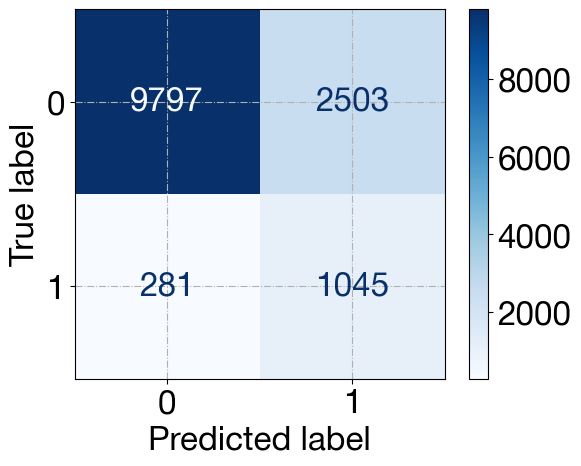

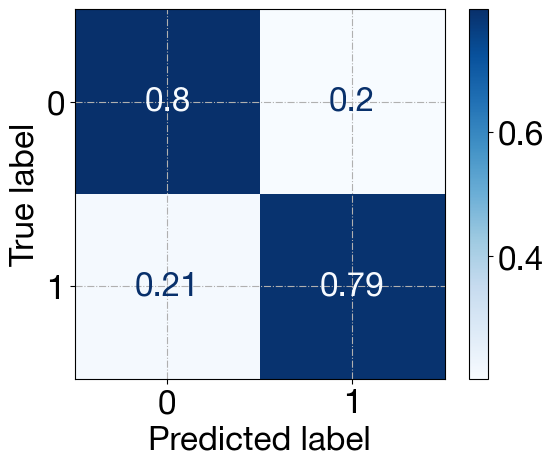

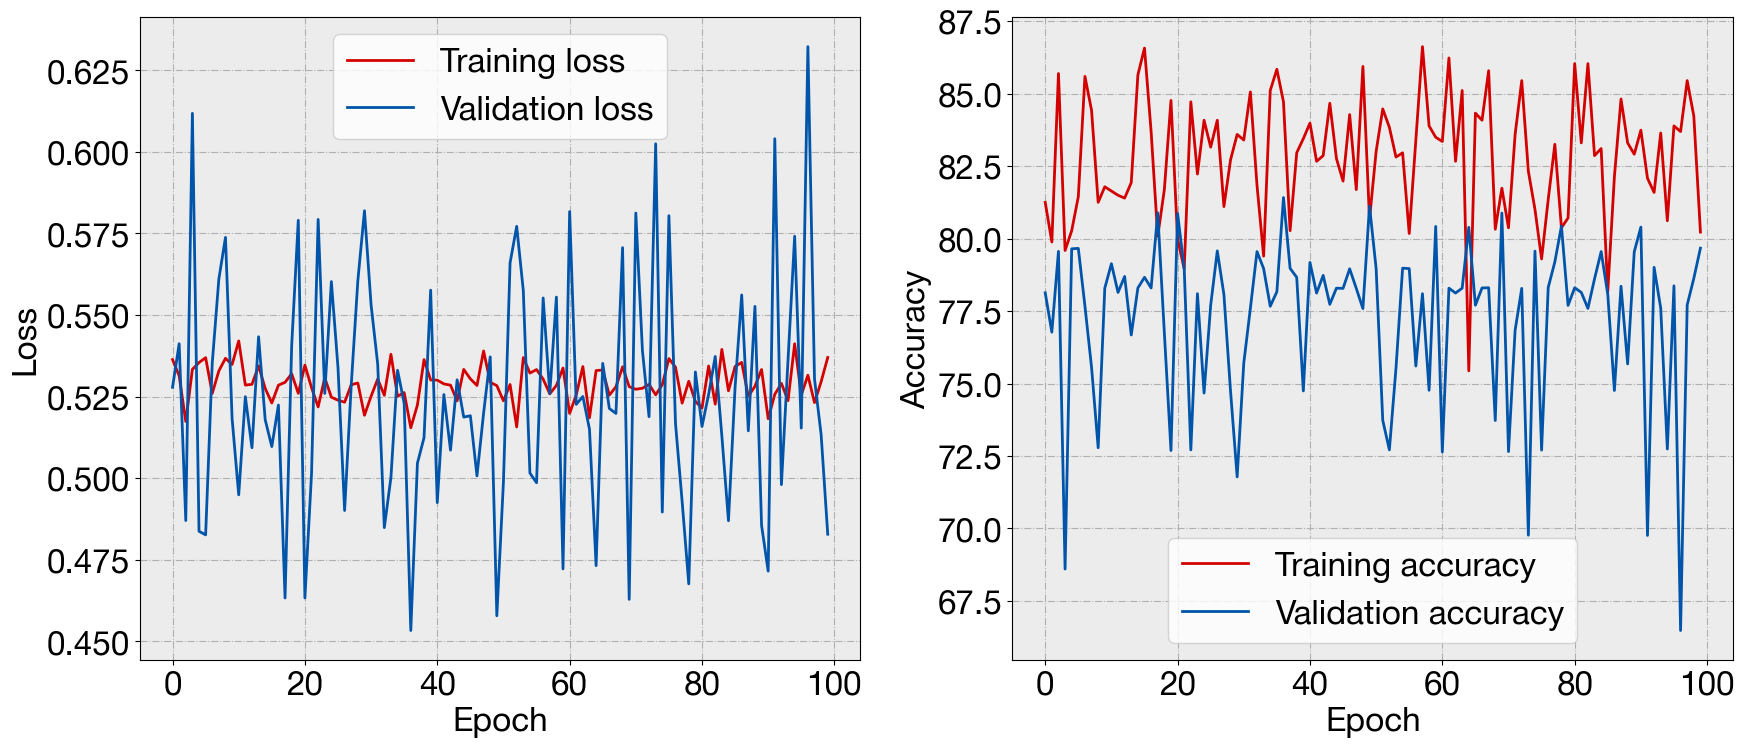

In [33]:
qnn_1, history_1, test_loss_1, test_acc_1 = run_experiment(
        feature_map_name = "fm1",
        ansatz_name = "ansatz1",
        layers = 2,
        n_epochs = 100,
        n_batches = 64,
        batch_size = 32,
        min_learn_rate = 1e-3,
        max_learn_rate = 1e-1)

Model: 3 layer(s), angle_shape = (3, 5)

Training Configuration:
  1. Feature map: fm1
  2. Ansatz: ansatz1
  3. Learning rate range: [0.001, 0.1]
  4. Device: cuda
  5. Total train batches available: 1988
  6. Batches per epoch: 64
  7. Epochs: 100



Epoch 1/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.03it/s]

Epoch 1/100: Train Loss = 0.5805, Train Acc = 72.31% | Val Loss = 0.4614, Val Acc = 80.89%



Epoch 2/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.06it/s]

Epoch 2/100: Train Loss = 0.5221, Train Acc = 83.74% | Val Loss = 0.5607, Val Acc = 74.57%



Epoch 3/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.99it/s]

Epoch 3/100: Train Loss = 0.5257, Train Acc = 81.45% | Val Loss = 0.4609, Val Acc = 80.81%



Epoch 4/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.94it/s]


Epoch 4/100: Train Loss = 0.5124, Train Acc = 82.67% | Val Loss = 0.5418, Val Acc = 76.48%


Epoch 5/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.96it/s]

Epoch 5/100: Train Loss = 0.5198, Train Acc = 82.62% | Val Loss = 0.5390, Val Acc = 76.43%



Epoch 6/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.90it/s]

Epoch 6/100: Train Loss = 0.5121, Train Acc = 84.47% | Val Loss = 0.4984, Val Acc = 79.11%



Epoch 7/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.02it/s]

Epoch 7/100: Train Loss = 0.5124, Train Acc = 83.15% | Val Loss = 0.4872, Val Acc = 79.77%



Epoch 8/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.96it/s]

Epoch 8/100: Train Loss = 0.5145, Train Acc = 84.03% | Val Loss = 0.5266, Val Acc = 77.68%



Epoch 9/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.86it/s]

Epoch 9/100: Train Loss = 0.5128, Train Acc = 84.18% | Val Loss = 0.5037, Val Acc = 78.86%



Epoch 10/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.98it/s]

Epoch 10/100: Train Loss = 0.5272, Train Acc = 81.15% | Val Loss = 0.5215, Val Acc = 77.75%



Epoch 11/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.93it/s]

Epoch 11/100: Train Loss = 0.5151, Train Acc = 84.23% | Val Loss = 0.4629, Val Acc = 80.95%



Epoch 12/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.98it/s]

Epoch 12/100: Train Loss = 0.5226, Train Acc = 79.44% | Val Loss = 0.5151, Val Acc = 78.43%



Epoch 13/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.01it/s]

Epoch 13/100: Train Loss = 0.5173, Train Acc = 82.42% | Val Loss = 0.4968, Val Acc = 79.17%



Epoch 14/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.96it/s]

Epoch 14/100: Train Loss = 0.5223, Train Acc = 82.23% | Val Loss = 0.5142, Val Acc = 78.48%



Epoch 15/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.89it/s]

Epoch 15/100: Train Loss = 0.5001, Train Acc = 86.77% | Val Loss = 0.5047, Val Acc = 78.95%



Epoch 16/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.01it/s]

Epoch 16/100: Train Loss = 0.5143, Train Acc = 80.96% | Val Loss = 0.4857, Val Acc = 79.83%



Epoch 17/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.96it/s]

Epoch 17/100: Train Loss = 0.5181, Train Acc = 84.28% | Val Loss = 0.5410, Val Acc = 76.57%



Epoch 18/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.92it/s]

Epoch 18/100: Train Loss = 0.5129, Train Acc = 81.88% | Val Loss = 0.5231, Val Acc = 77.60%



Epoch 19/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.05it/s]

Epoch 19/100: Train Loss = 0.5295, Train Acc = 80.32% | Val Loss = 0.5317, Val Acc = 76.93%



Epoch 20/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.90it/s]

Epoch 20/100: Train Loss = 0.5139, Train Acc = 84.08% | Val Loss = 0.5337, Val Acc = 77.09%



Epoch 21/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.86it/s]

Epoch 21/100: Train Loss = 0.5270, Train Acc = 84.33% | Val Loss = 0.5373, Val Acc = 76.95%



Epoch 22/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.00it/s]


Epoch 22/100: Train Loss = 0.5205, Train Acc = 80.66% | Val Loss = 0.4185, Val Acc = 82.92%


Epoch 23/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.95it/s]

Epoch 23/100: Train Loss = 0.5245, Train Acc = 79.93% | Val Loss = 0.5253, Val Acc = 77.70%



Epoch 24/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.01it/s]

Epoch 24/100: Train Loss = 0.5097, Train Acc = 84.47% | Val Loss = 0.5322, Val Acc = 77.26%



Epoch 25/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.93it/s]

Epoch 25/100: Train Loss = 0.5124, Train Acc = 84.62% | Val Loss = 0.5556, Val Acc = 74.95%



Epoch 26/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.91it/s]

Epoch 26/100: Train Loss = 0.5140, Train Acc = 86.38% | Val Loss = 0.5637, Val Acc = 74.59%



Epoch 27/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.90it/s]

Epoch 27/100: Train Loss = 0.5171, Train Acc = 84.08% | Val Loss = 0.4880, Val Acc = 79.73%



Epoch 28/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.95it/s]

Epoch 28/100: Train Loss = 0.5250, Train Acc = 81.30% | Val Loss = 0.5259, Val Acc = 77.85%



Epoch 29/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.94it/s]

Epoch 29/100: Train Loss = 0.5188, Train Acc = 82.71% | Val Loss = 0.4889, Val Acc = 79.83%



Epoch 30/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.86it/s]

Epoch 30/100: Train Loss = 0.5213, Train Acc = 83.94% | Val Loss = 0.5439, Val Acc = 76.26%



Epoch 31/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.89it/s]


Epoch 31/100: Train Loss = 0.5191, Train Acc = 83.01% | Val Loss = 0.4874, Val Acc = 79.76%


Epoch 32/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.03it/s]

Epoch 32/100: Train Loss = 0.5196, Train Acc = 84.52% | Val Loss = 0.5353, Val Acc = 76.93%



Epoch 33/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.88it/s]

Epoch 33/100: Train Loss = 0.5238, Train Acc = 83.89% | Val Loss = 0.5639, Val Acc = 74.41%



Epoch 34/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.91it/s]

Epoch 34/100: Train Loss = 0.5217, Train Acc = 84.77% | Val Loss = 0.4948, Val Acc = 79.50%



Epoch 35/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.03it/s]

Epoch 35/100: Train Loss = 0.5194, Train Acc = 84.08% | Val Loss = 0.5560, Val Acc = 75.28%



Epoch 36/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.91it/s]

Epoch 36/100: Train Loss = 0.5172, Train Acc = 83.54% | Val Loss = 0.4879, Val Acc = 80.29%



Epoch 37/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.91it/s]

Epoch 37/100: Train Loss = 0.5185, Train Acc = 82.81% | Val Loss = 0.5497, Val Acc = 75.36%



Epoch 38/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.96it/s]

Epoch 38/100: Train Loss = 0.5198, Train Acc = 84.38% | Val Loss = 0.5416, Val Acc = 76.54%



Epoch 39/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.95it/s]

Epoch 39/100: Train Loss = 0.5243, Train Acc = 82.03% | Val Loss = 0.4915, Val Acc = 79.60%



Epoch 40/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.91it/s]

Epoch 40/100: Train Loss = 0.5185, Train Acc = 83.94% | Val Loss = 0.5132, Val Acc = 78.09%



Epoch 41/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.95it/s]

Epoch 41/100: Train Loss = 0.5174, Train Acc = 83.89% | Val Loss = 0.4780, Val Acc = 80.24%



Epoch 42/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.95it/s]

Epoch 42/100: Train Loss = 0.5189, Train Acc = 81.40% | Val Loss = 0.5659, Val Acc = 74.33%



Epoch 43/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.87it/s]


Epoch 43/100: Train Loss = 0.5221, Train Acc = 83.25% | Val Loss = 0.5274, Val Acc = 77.56%


Epoch 44/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.05it/s]

Epoch 44/100: Train Loss = 0.5217, Train Acc = 82.42% | Val Loss = 0.5183, Val Acc = 78.52%



Epoch 45/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.05it/s]

Epoch 45/100: Train Loss = 0.5308, Train Acc = 81.01% | Val Loss = 0.5095, Val Acc = 78.55%



Epoch 46/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.09it/s]

Epoch 46/100: Train Loss = 0.5126, Train Acc = 83.54% | Val Loss = 0.5295, Val Acc = 77.46%



Epoch 47/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.07it/s]

Epoch 47/100: Train Loss = 0.5296, Train Acc = 78.27% | Val Loss = 0.5364, Val Acc = 76.34%



Epoch 48/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.08it/s]

Epoch 48/100: Train Loss = 0.5173, Train Acc = 84.03% | Val Loss = 0.5388, Val Acc = 76.80%



Epoch 49/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.04it/s]

Epoch 49/100: Train Loss = 0.5185, Train Acc = 83.15% | Val Loss = 0.6274, Val Acc = 68.39%



Epoch 50/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.00it/s]

Epoch 50/100: Train Loss = 0.5123, Train Acc = 84.52% | Val Loss = 0.5101, Val Acc = 78.52%



Epoch 51/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.06it/s]

Epoch 51/100: Train Loss = 0.5224, Train Acc = 82.18% | Val Loss = 0.5086, Val Acc = 78.68%



Epoch 52/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.11it/s]

Epoch 52/100: Train Loss = 0.5155, Train Acc = 84.52% | Val Loss = 0.5259, Val Acc = 77.86%



Epoch 53/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.98it/s]

Epoch 53/100: Train Loss = 0.5170, Train Acc = 86.23% | Val Loss = 0.5247, Val Acc = 77.50%



Epoch 54/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.12it/s]

Epoch 54/100: Train Loss = 0.5284, Train Acc = 83.74% | Val Loss = 0.4898, Val Acc = 80.10%



Epoch 55/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.04it/s]

Epoch 55/100: Train Loss = 0.5237, Train Acc = 79.64% | Val Loss = 0.4410, Val Acc = 81.75%



Epoch 56/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.05it/s]

Epoch 56/100: Train Loss = 0.5240, Train Acc = 81.69% | Val Loss = 0.5741, Val Acc = 73.42%



Epoch 57/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.96it/s]

Epoch 57/100: Train Loss = 0.5231, Train Acc = 79.79% | Val Loss = 0.4690, Val Acc = 80.57%



Epoch 58/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.09it/s]

Epoch 58/100: Train Loss = 0.5133, Train Acc = 80.32% | Val Loss = 0.5109, Val Acc = 78.39%



Epoch 59/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.03it/s]

Epoch 59/100: Train Loss = 0.5245, Train Acc = 82.42% | Val Loss = 0.5275, Val Acc = 77.80%



Epoch 60/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.02it/s]


Epoch 60/100: Train Loss = 0.5115, Train Acc = 83.54% | Val Loss = 0.5031, Val Acc = 79.03%


Epoch 61/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.01it/s]

Epoch 61/100: Train Loss = 0.5257, Train Acc = 83.94% | Val Loss = 0.5632, Val Acc = 74.84%



Epoch 62/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.01it/s]

Epoch 62/100: Train Loss = 0.5248, Train Acc = 78.86% | Val Loss = 0.5044, Val Acc = 78.94%



Epoch 63/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.07it/s]

Epoch 63/100: Train Loss = 0.5170, Train Acc = 81.35% | Val Loss = 0.5296, Val Acc = 77.67%



Epoch 64/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.04it/s]

Epoch 64/100: Train Loss = 0.5114, Train Acc = 84.77% | Val Loss = 0.5164, Val Acc = 78.04%



Epoch 65/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.06it/s]

Epoch 65/100: Train Loss = 0.5093, Train Acc = 83.69% | Val Loss = 0.4997, Val Acc = 79.30%



Epoch 66/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.97it/s]

Epoch 66/100: Train Loss = 0.5097, Train Acc = 84.57% | Val Loss = 0.5464, Val Acc = 76.73%



Epoch 67/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.07it/s]

Epoch 67/100: Train Loss = 0.5221, Train Acc = 83.84% | Val Loss = 0.5094, Val Acc = 78.64%



Epoch 68/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.13it/s]

Epoch 68/100: Train Loss = 0.5129, Train Acc = 84.47% | Val Loss = 0.4736, Val Acc = 80.51%



Epoch 69/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.05it/s]

Epoch 69/100: Train Loss = 0.5195, Train Acc = 80.81% | Val Loss = 0.4885, Val Acc = 79.39%



Epoch 70/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.06it/s]

Epoch 70/100: Train Loss = 0.5382, Train Acc = 78.61% | Val Loss = 0.5005, Val Acc = 78.93%



Epoch 71/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.12it/s]

Epoch 71/100: Train Loss = 0.5126, Train Acc = 83.20% | Val Loss = 0.4946, Val Acc = 79.63%



Epoch 72/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.98it/s]

Epoch 72/100: Train Loss = 0.5243, Train Acc = 82.23% | Val Loss = 0.5035, Val Acc = 78.88%



Epoch 73/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.10it/s]

Epoch 73/100: Train Loss = 0.5256, Train Acc = 83.45% | Val Loss = 0.5149, Val Acc = 78.11%



Epoch 74/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.07it/s]

Epoch 74/100: Train Loss = 0.5123, Train Acc = 82.91% | Val Loss = 0.4771, Val Acc = 80.15%



Epoch 75/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.98it/s]

Epoch 75/100: Train Loss = 0.5166, Train Acc = 80.96% | Val Loss = 0.5478, Val Acc = 76.12%



Epoch 76/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.01it/s]

Epoch 76/100: Train Loss = 0.5239, Train Acc = 82.03% | Val Loss = 0.4534, Val Acc = 81.38%



Epoch 77/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.11it/s]

Epoch 77/100: Train Loss = 0.5205, Train Acc = 80.27% | Val Loss = 0.4860, Val Acc = 79.85%



Epoch 78/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.01it/s]


Epoch 78/100: Train Loss = 0.5125, Train Acc = 82.03% | Val Loss = 0.5666, Val Acc = 73.90%


Epoch 79/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.10it/s]

Epoch 79/100: Train Loss = 0.5194, Train Acc = 80.47% | Val Loss = 0.4422, Val Acc = 81.83%



Epoch 80/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.06it/s]

Epoch 80/100: Train Loss = 0.5153, Train Acc = 80.76% | Val Loss = 0.5623, Val Acc = 74.46%



Epoch 81/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.03it/s]

Epoch 81/100: Train Loss = 0.5202, Train Acc = 84.18% | Val Loss = 0.4692, Val Acc = 80.57%



Epoch 82/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.03it/s]

Epoch 82/100: Train Loss = 0.5226, Train Acc = 81.01% | Val Loss = 0.5231, Val Acc = 78.05%



Epoch 83/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.04it/s]

Epoch 83/100: Train Loss = 0.5159, Train Acc = 85.16% | Val Loss = 0.5197, Val Acc = 77.95%



Epoch 84/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.03it/s]

Epoch 84/100: Train Loss = 0.5224, Train Acc = 81.69% | Val Loss = 0.4944, Val Acc = 79.27%



Epoch 85/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.07it/s]

Epoch 85/100: Train Loss = 0.5194, Train Acc = 80.27% | Val Loss = 0.5027, Val Acc = 78.99%



Epoch 86/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.00it/s]

Epoch 86/100: Train Loss = 0.5196, Train Acc = 81.93% | Val Loss = 0.4955, Val Acc = 79.33%



Epoch 87/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.08it/s]

Epoch 87/100: Train Loss = 0.5134, Train Acc = 85.11% | Val Loss = 0.5539, Val Acc = 75.30%



Epoch 88/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.10it/s]

Epoch 88/100: Train Loss = 0.5158, Train Acc = 84.33% | Val Loss = 0.5095, Val Acc = 78.56%



Epoch 89/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.02it/s]

Epoch 89/100: Train Loss = 0.5121, Train Acc = 83.06% | Val Loss = 0.4929, Val Acc = 79.39%



Epoch 90/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.02it/s]

Epoch 90/100: Train Loss = 0.5242, Train Acc = 80.13% | Val Loss = 0.5723, Val Acc = 73.60%



Epoch 91/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.98it/s]

Epoch 91/100: Train Loss = 0.5118, Train Acc = 82.37% | Val Loss = 0.4969, Val Acc = 79.14%



Epoch 92/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.07it/s]

Epoch 92/100: Train Loss = 0.5247, Train Acc = 82.03% | Val Loss = 0.5012, Val Acc = 79.10%



Epoch 93/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.07it/s]

Epoch 93/100: Train Loss = 0.5186, Train Acc = 82.91% | Val Loss = 0.5144, Val Acc = 78.55%



Epoch 94/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.03it/s]

Epoch 94/100: Train Loss = 0.5192, Train Acc = 85.16% | Val Loss = 0.5705, Val Acc = 73.86%



Epoch 95/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.03it/s]

Epoch 95/100: Train Loss = 0.5217, Train Acc = 80.27% | Val Loss = 0.6121, Val Acc = 69.54%



Epoch 96/100 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.06it/s]

Epoch 96/100: Train Loss = 0.5145, Train Acc = 82.08% | Val Loss = 0.5287, Val Acc = 77.68%



Epoch 97/100 [Val]  : 100%|██████████| 426/426 [00:32<00:00, 13.00it/s]

Epoch 97/100: Train Loss = 0.5207, Train Acc = 82.71% | Val Loss = 0.4792, Val Acc = 80.10%



Epoch 98/100 [Val]  : 100%|██████████| 426/426 [00:34<00:00, 12.23it/s]

Epoch 98/100: Train Loss = 0.5140, Train Acc = 81.05% | Val Loss = 0.4610, Val Acc = 81.01%



Epoch 99/100 [Val]  : 100%|██████████| 426/426 [00:34<00:00, 12.30it/s]

Epoch 99/100: Train Loss = 0.5191, Train Acc = 83.59% | Val Loss = 0.5424, Val Acc = 76.67%



Epoch 100/100 [Val]  : 100%|██████████| 426/426 [00:35<00:00, 11.95it/s]


Epoch 100/100: Train Loss = 0.5204, Train Acc = 82.62% | Val Loss = 0.5571, Val Acc = 75.37%

TESTING PHASE


Testing: 100%|██████████| 426/426 [00:34<00:00, 12.50it/s]



Test Loss: 0.5580
Test Accuracy: 0.7489 (74.89%)

Classification Report:
               precision    recall  f1-score   support

Not Hazardous       1.00      0.72      0.84     12300
    Hazardous       0.28      1.00      0.44      1326

     accuracy                           0.75     13626
    macro avg       0.64      0.86      0.64     13626
 weighted avg       0.93      0.75      0.80     13626


Confusion Matrix:
[[8880 3420]
 [   2 1324]]
[[72.2  27.8 ]
 [ 0.15 99.85]]


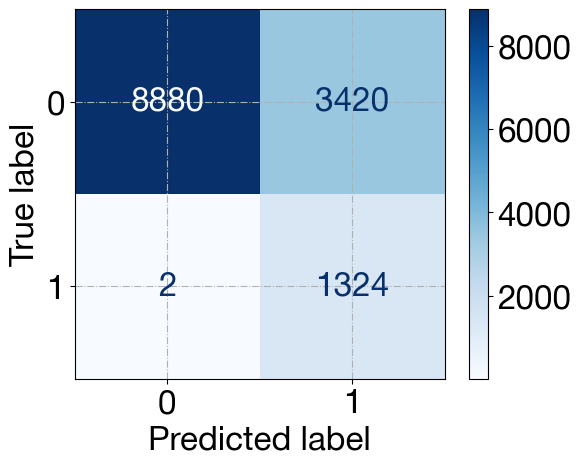

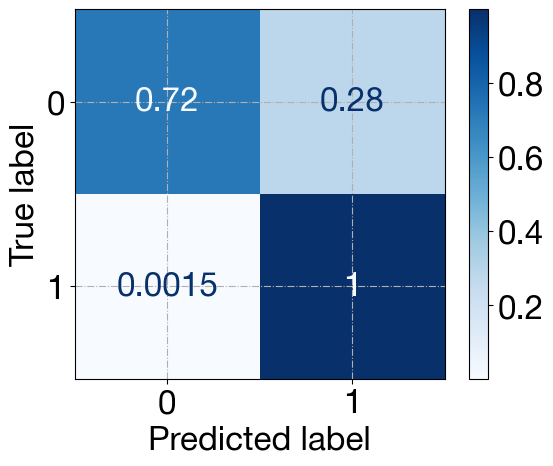

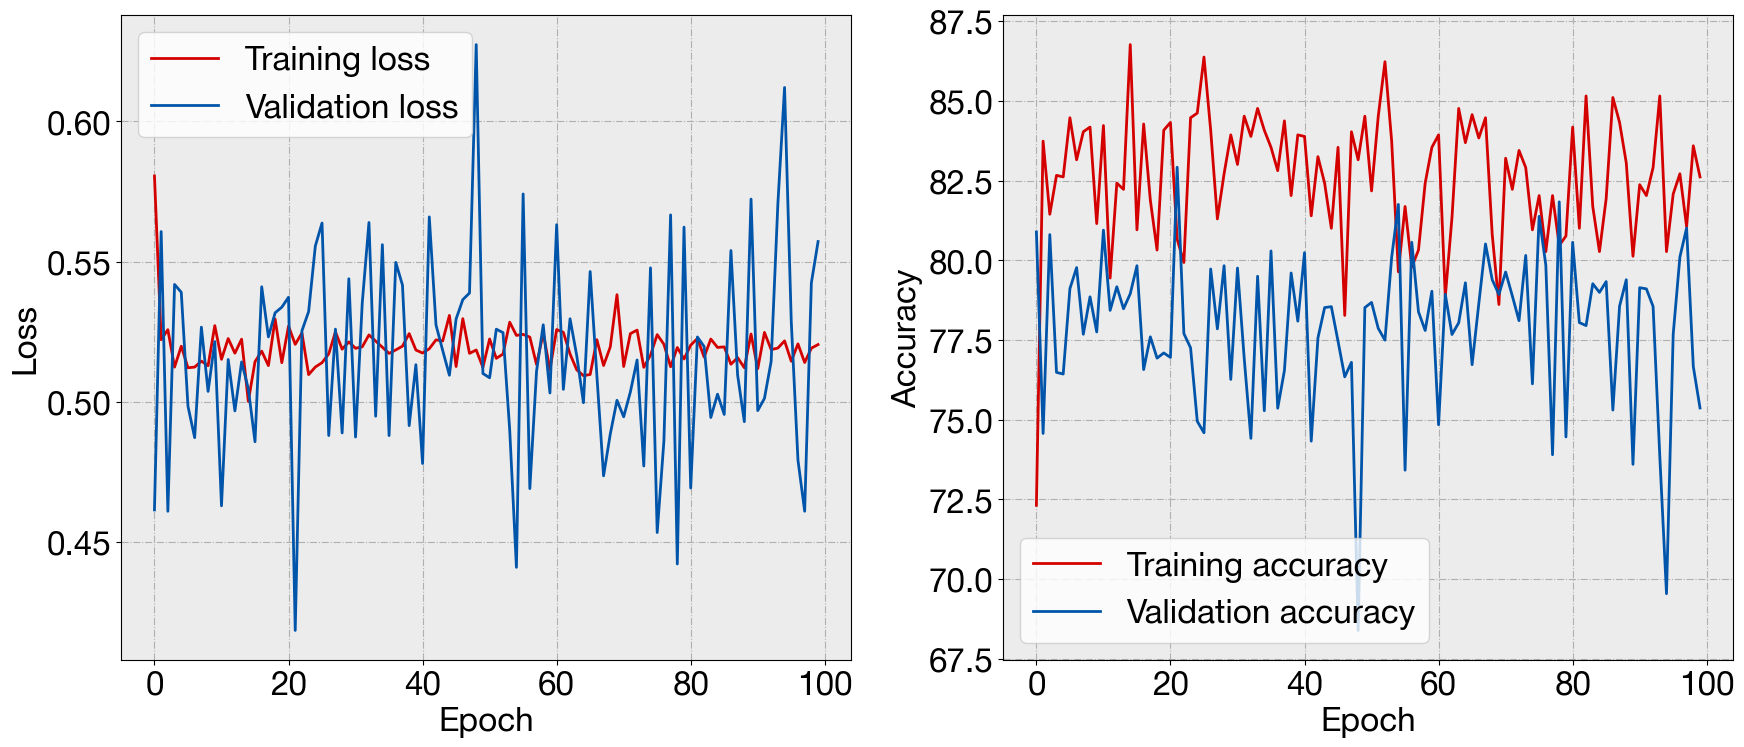

In [31]:
qnn_2, history_2, test_loss_2, test_acc_2 = run_experiment(
        feature_map_name = "fm1",
        ansatz_name = "ansatz1",
        layers = 3,
        n_epochs = 100,
        n_batches = 64,
        batch_size = 32,
        min_learn_rate = 1e-3,
        max_learn_rate = 1e-1)

Model: 2 layer(s), angle_shape = (2, 5)

Training Configuration:
  1. Feature map: fm2
  2. Ansatz: ansatz1
  3. Learning rate range: [0.001, 0.1]
  4. Device: cuda
  5. Total train batches available: 1988
  6. Batches per epoch: 96
  7. Epochs: 50



Epoch 1/50 [Val]  : 100%|██████████| 426/426 [00:34<00:00, 12.52it/s]

Epoch 1/50: Train Loss = 0.5607, Train Acc = 80.18% | Val Loss = 0.5448, Val Acc = 75.05%



Epoch 2/50 [Val]  : 100%|██████████| 426/426 [00:34<00:00, 12.22it/s]

Epoch 2/50: Train Loss = 0.5546, Train Acc = 81.48% | Val Loss = 0.5523, Val Acc = 74.08%



Epoch 3/50 [Val]  : 100%|██████████| 426/426 [00:34<00:00, 12.27it/s]

Epoch 3/50: Train Loss = 0.5542, Train Acc = 82.32% | Val Loss = 0.5241, Val Acc = 77.65%



Epoch 4/50 [Val]  : 100%|██████████| 426/426 [00:35<00:00, 12.06it/s]

Epoch 4/50: Train Loss = 0.5536, Train Acc = 80.24% | Val Loss = 0.4953, Val Acc = 80.21%



Epoch 5/50 [Val]  : 100%|██████████| 426/426 [00:32<00:00, 13.03it/s]

Epoch 5/50: Train Loss = 0.5490, Train Acc = 82.52% | Val Loss = 0.5532, Val Acc = 73.96%



Epoch 6/50 [Val]  : 100%|██████████| 426/426 [00:34<00:00, 12.42it/s]

Epoch 6/50: Train Loss = 0.5518, Train Acc = 82.10% | Val Loss = 0.5514, Val Acc = 74.14%



Epoch 7/50 [Val]  : 100%|██████████| 426/426 [00:34<00:00, 12.35it/s]

Epoch 7/50: Train Loss = 0.5564, Train Acc = 82.19% | Val Loss = 0.5440, Val Acc = 75.09%



Epoch 8/50 [Val]  : 100%|██████████| 426/426 [00:34<00:00, 12.35it/s]

Epoch 8/50: Train Loss = 0.5531, Train Acc = 82.32% | Val Loss = 0.5733, Val Acc = 71.35%



Epoch 9/50 [Val]  : 100%|██████████| 426/426 [00:33<00:00, 12.87it/s]

Epoch 9/50: Train Loss = 0.5535, Train Acc = 81.71% | Val Loss = 0.5569, Val Acc = 73.52%



Epoch 10/50 [Val]  : 100%|██████████| 426/426 [00:35<00:00, 11.85it/s]

Epoch 10/50: Train Loss = 0.5496, Train Acc = 81.25% | Val Loss = 0.5401, Val Acc = 75.48%



Epoch 11/50 [Val]  : 100%|██████████| 426/426 [00:34<00:00, 12.28it/s]

Epoch 11/50: Train Loss = 0.5518, Train Acc = 82.62% | Val Loss = 0.6054, Val Acc = 67.24%



Epoch 12/50 [Val]  : 100%|██████████| 426/426 [00:34<00:00, 12.36it/s]

Epoch 12/50: Train Loss = 0.5508, Train Acc = 82.36% | Val Loss = 0.5283, Val Acc = 77.03%



Epoch 13/50 [Val]  : 100%|██████████| 426/426 [00:33<00:00, 12.57it/s]

Epoch 13/50: Train Loss = 0.5485, Train Acc = 82.42% | Val Loss = 0.5118, Val Acc = 78.83%



Epoch 14/50 [Val]  : 100%|██████████| 426/426 [00:34<00:00, 12.26it/s]

Epoch 14/50: Train Loss = 0.5544, Train Acc = 83.24% | Val Loss = 0.5535, Val Acc = 73.92%



Epoch 15/50 [Val]  : 100%|██████████| 426/426 [00:35<00:00, 11.95it/s]

Epoch 15/50: Train Loss = 0.5478, Train Acc = 82.65% | Val Loss = 0.5292, Val Acc = 76.96%



Epoch 16/50 [Val]  : 100%|██████████| 426/426 [00:36<00:00, 11.71it/s]

Epoch 16/50: Train Loss = 0.5559, Train Acc = 81.48% | Val Loss = 0.5023, Val Acc = 79.60%



Epoch 17/50 [Val]  : 100%|██████████| 426/426 [00:29<00:00, 14.67it/s]

Epoch 17/50: Train Loss = 0.5550, Train Acc = 81.84% | Val Loss = 0.5754, Val Acc = 71.08%



Epoch 18/50 [Val]  : 100%|██████████| 426/426 [00:27<00:00, 15.42it/s]

Epoch 18/50: Train Loss = 0.5537, Train Acc = 81.45% | Val Loss = 0.5454, Val Acc = 74.94%



Epoch 19/50 [Val]  : 100%|██████████| 426/426 [00:27<00:00, 15.41it/s]

Epoch 19/50: Train Loss = 0.5537, Train Acc = 81.18% | Val Loss = 0.5609, Val Acc = 72.95%



Epoch 20/50 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.05it/s]

Epoch 20/50: Train Loss = 0.5544, Train Acc = 81.32% | Val Loss = 0.5241, Val Acc = 77.64%



Epoch 21/50 [Val]  : 100%|██████████| 426/426 [00:27<00:00, 15.31it/s]

Epoch 21/50: Train Loss = 0.5549, Train Acc = 80.21% | Val Loss = 0.5289, Val Acc = 77.01%



Epoch 22/50 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.99it/s]

Epoch 22/50: Train Loss = 0.5513, Train Acc = 81.35% | Val Loss = 0.5709, Val Acc = 71.65%



Epoch 23/50 [Val]  : 100%|██████████| 426/426 [00:27<00:00, 15.29it/s]

Epoch 23/50: Train Loss = 0.5544, Train Acc = 82.88% | Val Loss = 0.5412, Val Acc = 75.43%



Epoch 24/50 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.06it/s]

Epoch 24/50: Train Loss = 0.5520, Train Acc = 83.72% | Val Loss = 0.5430, Val Acc = 75.21%



Epoch 25/50 [Val]  : 100%|██████████| 426/426 [00:27<00:00, 15.31it/s]

Epoch 25/50: Train Loss = 0.5505, Train Acc = 83.27% | Val Loss = 0.5374, Val Acc = 75.82%



Epoch 26/50 [Val]  : 100%|██████████| 426/426 [00:27<00:00, 15.24it/s]

Epoch 26/50: Train Loss = 0.5513, Train Acc = 81.58% | Val Loss = 0.5544, Val Acc = 73.82%



Epoch 27/50 [Val]  : 100%|██████████| 426/426 [00:27<00:00, 15.38it/s]

Epoch 27/50: Train Loss = 0.5501, Train Acc = 82.49% | Val Loss = 0.5506, Val Acc = 74.26%



Epoch 28/50 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.06it/s]

Epoch 28/50: Train Loss = 0.5525, Train Acc = 80.18% | Val Loss = 0.5433, Val Acc = 75.19%



Epoch 29/50 [Val]  : 100%|██████████| 426/426 [00:27<00:00, 15.30it/s]

Epoch 29/50: Train Loss = 0.5573, Train Acc = 80.50% | Val Loss = 0.5543, Val Acc = 73.83%



Epoch 30/50 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.07it/s]

Epoch 30/50: Train Loss = 0.5554, Train Acc = 82.68% | Val Loss = 0.5244, Val Acc = 77.59%



Epoch 31/50 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.99it/s]

Epoch 31/50: Train Loss = 0.5588, Train Acc = 81.28% | Val Loss = 0.5434, Val Acc = 75.19%



Epoch 32/50 [Val]  : 100%|██████████| 426/426 [00:27<00:00, 15.33it/s]

Epoch 32/50: Train Loss = 0.5526, Train Acc = 81.41% | Val Loss = 0.5427, Val Acc = 75.27%



Epoch 33/50 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.13it/s]

Epoch 33/50: Train Loss = 0.5486, Train Acc = 82.68% | Val Loss = 0.5544, Val Acc = 73.82%



Epoch 34/50 [Val]  : 100%|██████████| 426/426 [00:27<00:00, 15.29it/s]

Epoch 34/50: Train Loss = 0.5492, Train Acc = 82.52% | Val Loss = 0.5847, Val Acc = 69.78%



Epoch 35/50 [Val]  : 100%|██████████| 426/426 [00:30<00:00, 14.17it/s]

Epoch 35/50: Train Loss = 0.5545, Train Acc = 81.32% | Val Loss = 0.5494, Val Acc = 74.42%



Epoch 36/50 [Val]  : 100%|██████████| 426/426 [00:27<00:00, 15.34it/s]

Epoch 36/50: Train Loss = 0.5507, Train Acc = 79.33% | Val Loss = 0.4859, Val Acc = 81.15%



Epoch 37/50 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.19it/s]

Epoch 37/50: Train Loss = 0.5529, Train Acc = 81.15% | Val Loss = 0.5162, Val Acc = 78.42%



Epoch 38/50 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.10it/s]

Epoch 38/50: Train Loss = 0.5529, Train Acc = 80.47% | Val Loss = 0.5376, Val Acc = 75.77%



Epoch 39/50 [Val]  : 100%|██████████| 426/426 [00:29<00:00, 14.48it/s]

Epoch 39/50: Train Loss = 0.5576, Train Acc = 81.35% | Val Loss = 0.5469, Val Acc = 74.83%



Epoch 40/50 [Val]  : 100%|██████████| 426/426 [00:31<00:00, 13.37it/s]

Epoch 40/50: Train Loss = 0.5501, Train Acc = 81.45% | Val Loss = 0.5612, Val Acc = 72.92%



Epoch 41/50 [Val]  : 100%|██████████| 426/426 [00:29<00:00, 14.23it/s]

Epoch 41/50: Train Loss = 0.5476, Train Acc = 82.00% | Val Loss = 0.5610, Val Acc = 72.92%



Epoch 42/50 [Val]  : 100%|██████████| 426/426 [00:29<00:00, 14.52it/s]

Epoch 42/50: Train Loss = 0.5516, Train Acc = 82.68% | Val Loss = 0.5453, Val Acc = 74.94%



Epoch 43/50 [Val]  : 100%|██████████| 426/426 [00:27<00:00, 15.49it/s]

Epoch 43/50: Train Loss = 0.5506, Train Acc = 83.46% | Val Loss = 0.5661, Val Acc = 72.29%



Epoch 44/50 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 14.92it/s]

Epoch 44/50: Train Loss = 0.5531, Train Acc = 81.90% | Val Loss = 0.5416, Val Acc = 75.41%



Epoch 45/50 [Val]  : 100%|██████████| 426/426 [00:29<00:00, 14.65it/s]

Epoch 45/50: Train Loss = 0.5602, Train Acc = 80.37% | Val Loss = 0.5901, Val Acc = 69.11%



Epoch 46/50 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.02it/s]

Epoch 46/50: Train Loss = 0.5544, Train Acc = 80.01% | Val Loss = 0.5733, Val Acc = 71.34%



Epoch 47/50 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.08it/s]

Epoch 47/50: Train Loss = 0.5565, Train Acc = 81.18% | Val Loss = 0.5389, Val Acc = 75.62%



Epoch 48/50 [Val]  : 100%|██████████| 426/426 [00:28<00:00, 15.00it/s]

Epoch 48/50: Train Loss = 0.5483, Train Acc = 82.81% | Val Loss = 0.5658, Val Acc = 72.34%



Epoch 49/50 [Val]  : 100%|██████████| 426/426 [00:29<00:00, 14.65it/s]

Epoch 49/50: Train Loss = 0.5594, Train Acc = 82.45% | Val Loss = 0.5365, Val Acc = 75.99%



Epoch 50/50 [Val]  : 100%|██████████| 426/426 [00:27<00:00, 15.33it/s]


Epoch 50/50: Train Loss = 0.5514, Train Acc = 82.71% | Val Loss = 0.5492, Val Acc = 74.40%

TESTING PHASE


Testing: 100%|██████████| 426/426 [00:29<00:00, 14.62it/s]



Test Loss: 0.5497
Test Accuracy: 0.7428 (74.28%)

Classification Report:
               precision    recall  f1-score   support

Not Hazardous       0.99      0.72      0.84     12300
    Hazardous       0.27      0.94      0.42      1326

     accuracy                           0.74     13626
    macro avg       0.63      0.83      0.63     13626
 weighted avg       0.92      0.74      0.79     13626


Confusion Matrix:
[[8873 3427]
 [  78 1248]]
[[72.14 27.86]
 [ 5.88 94.12]]


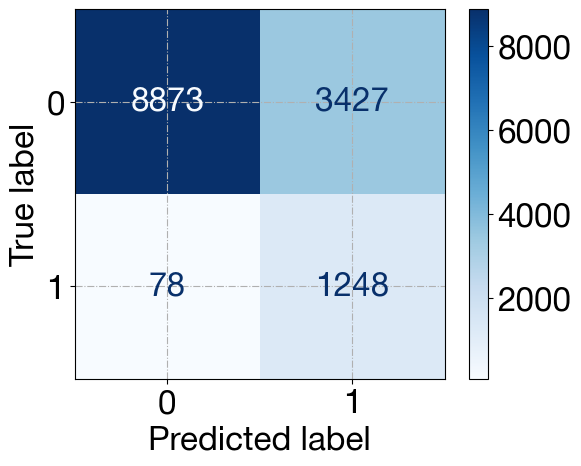

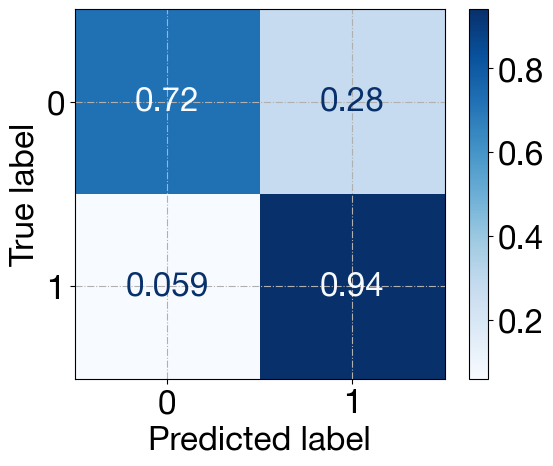

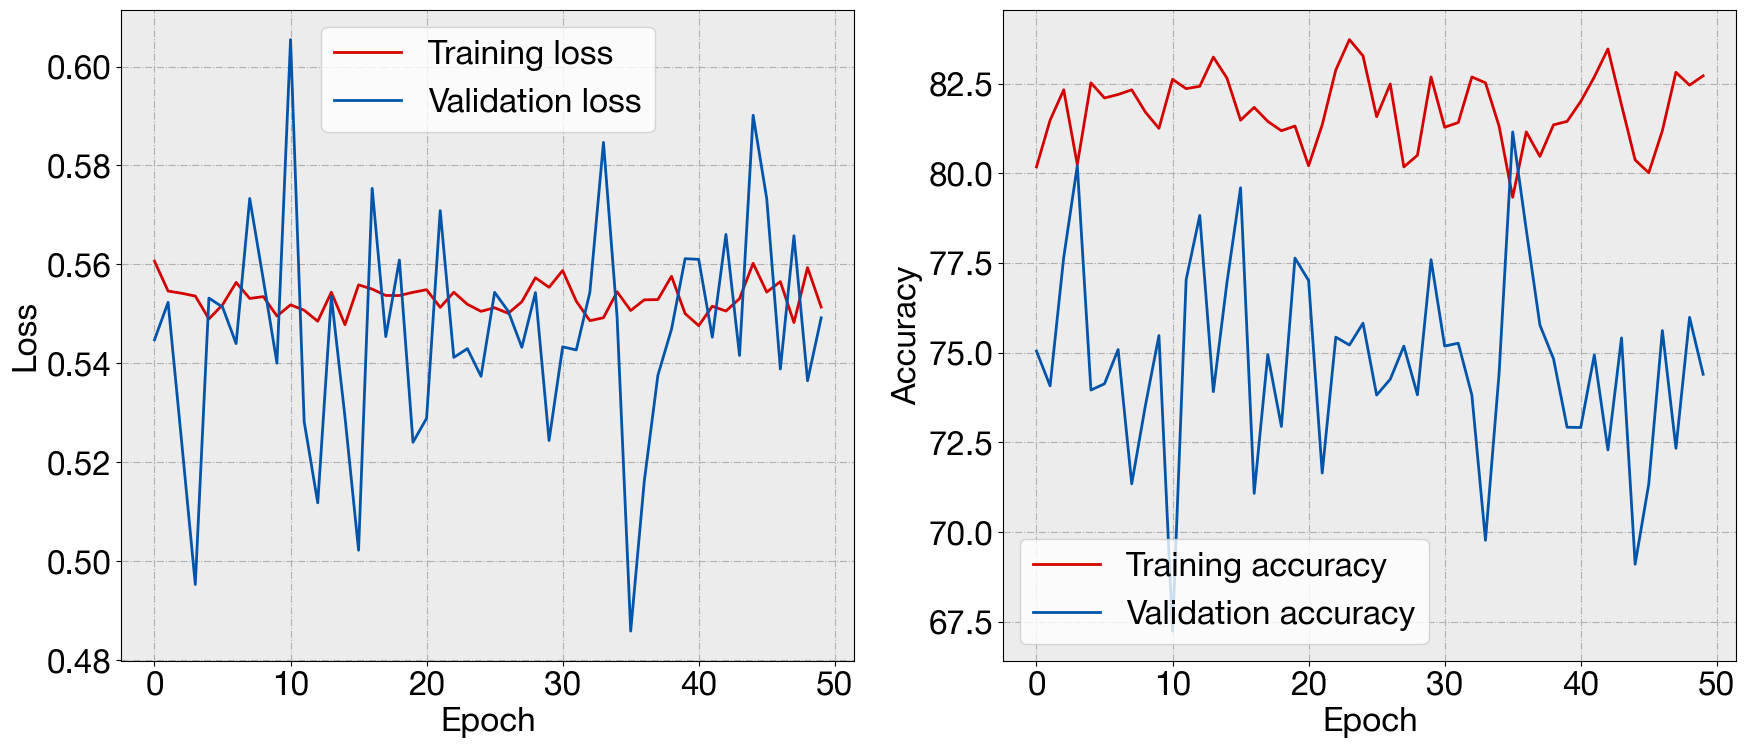

In [32]:
qnn_3, history_3, test_loss_3, test_acc_3 = run_experiment(
        feature_map_name = "fm2",
        ansatz_name = "ansatz1",
        layers = 2,
        n_epochs = 50,
        n_batches = 96,
        batch_size = 32,
        min_learn_rate = 1e-3,
        max_learn_rate = 1e-1)